# Run on the full dataset

## Setting up environment

In [1]:
import os
from glob import glob

import dask
import dask.bag as db
import dask.dataframe as dd
from distributed import Client
from dask_jobqueue import SLURMCluster

from IPython.display import display
import matplotlib.pyplot as plt

import logging
import pickle

from lenskit.batch import MultiEval, predict, recommend
from lenskit.crossfold import partition_users, SampleN
from lenskit.algorithms import basic, als, svd, bias
from lenskit import topn, util, Recommender, batch
from lenskit.topn import precision, ndcg, recall

import pandas as pd
import numpy as np
from scipy import stats
import binpickle

import argparse
import time

from tqdm.auto import tqdm

In [2]:
# Set LOCAL to True for single-machine execution while developing
# Set LOCAL to False for cluster execution
LOCAL = True

if LOCAL:
    # This line creates a single-machine dask client
    client = Client()
else:    
    # This line creates a SLURM cluster dask and dask client
    # Logging outputs will be stored in /scratch/{your-netid}
    
    cluster = SLURMCluster(memory='4GB', cores=2, python='/scratch/work/public/dask/bin/python', 
                               local_directory='/tmp/{}/'.format(os.environ['SLURM_JOB_USER']),
                               job_extra=['--output=/scratch/{}/slurm-%j.out'.format(os.environ['SLURM_JOB_USER'])])

    cluster.submit_command = 'slurm'
    cluster.scale(100)

    display(cluster)
    client = Client(cluster)

display(client)

/ext3/miniconda3/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43215 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:34013 Dashboard: http://127.0.0.1:43215/status,Cluster Workers: 1 Cores: 1 Memory: 17.18 GB


## Load data

In [3]:
# use the 100 subtrain version for tuning
train_dir = '/scratch/zh2095/quarantini/cf_train.parquet'
test_dir = '/scratch/zh2095/quarantini/cf_val.parquet'

In [4]:
start = time.time()

df_train = pd.read_parquet(train_dir)
df_test = pd.read_parquet(test_dir)

print('took %f s'%(time.time()-start))

took 33.674726 s


In [5]:
df_train.rename(columns = {'user_id':'user', 'track_id':'item', 'count':'rating'}, inplace = True)
df_test.rename(columns = {'user_id':'user', 'track_id':'item', 'count':'rating'}, inplace = True)

In [6]:
df_train.reset_index(drop=True, inplace=True)

In [7]:
# take a look at the full dataset
df_train

,user,rating,item
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1,TRIQAUQ128F42435AD
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1,TRIRLYL128F42539D1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,2,TRMHBXZ128F4238406
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1,TRYQMNI128F147C1C7
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1,TRAHZNE128F9341B86
...,...,...,...
49824514,ffff07d7d9bb187aa58c7b81b3d3f35e7cf7c0ee,5,TRCAQLO128F4284DD0
49824515,ffff07d7d9bb187aa58c7b81b3d3f35e7cf7c0ee,1,TRLIWUN128F145D610
49824516,ffff07d7d9bb187aa58c7b81b3d3f35e7cf7c0ee,25,TRXFYCU128F4258741
49824517,ffff07d7d9bb187aa58c7b81b3d3f35e7cf7c0ee,1,TRBHKVD128F146F758


# Plots and further tune on features

In [70]:
feature_set = [10, 20, 50, 100]
reg = 1
weight = 10
iterations = 20
use_ratings = True

data = (df_train, df_test)

In [9]:
eval = MultiEval('result_full', recommend=500, save_models=False)  #set save_models=True when running on the full dataset
eval.add_datasets(data, name='Song')   

ALS = [als.ImplicitMF(features=f, iterations=iterations, reg=reg, weight=weight, use_ratings=use_ratings, method='cg', progress=tqdm) 
                        for f in feature_set]

eval.add_algorithms(ALS, attrs=['features'], name='ImplicitMF')

eval.run(progress = tqdm)

initializing deprecated MultiEval


  0%|          | 0/4 [00:00<?, ?it/s]

ImplicitMF:   0%|          | 0/20 [00:00<?, ?it/s]

ImplicitMF:   0%|          | 0/20 [00:00<?, ?it/s]

ImplicitMF:   0%|          | 0/20 [00:00<?, ?it/s]

ImplicitMF:   0%|          | 0/20 [00:00<?, ?it/s]

In [64]:
runs_test = pd.read_csv('result_full/runs.csv')
runs_test.set_index('RunId', inplace=True)
runs_test.head()

,DataSet,AlgoClass,AlgoStr,name,features,TrainTime,PredTime,RecTime
RunId,,,,,,,,
1,Song,ImplicitMF,"als.ImplicitMF(features=10, reg=1, w=10)",ImplicitMF,10,561.432177,40.766977,1650.955631
2,Song,ImplicitMF,"als.ImplicitMF(features=20, reg=1, w=10)",ImplicitMF,20,572.794609,38.163735,1634.182680
3,Song,ImplicitMF,"als.ImplicitMF(features=50, reg=1, w=10)",ImplicitMF,50,854.963907,39.713855,2058.651239
4,Song,ImplicitMF,"als.ImplicitMF(features=100, reg=1, w=10)",ImplicitMF,100,1319.579091,40.797067,2640.018421


In [65]:
recs_test = pd.read_parquet('result_full/recommendations.parquet')

In [66]:
rla = topn.RecListAnalysis()
rla.add_metric(precision, k=500)
rla.add_metric(ndcg, k=500)
rla.add_metric(recall, k=500)

raw_metrics = rla.compute(recs_test, df_test,  include_missing=False)
raw_metrics = raw_metrics.join(runs_test[['features', 'TrainTime', 'RecTime']], on='RunId')
raw_metrics.head()

nrecs  precision      ndcg  \
RunId user                                                                   
1     0007140a3796e901f3190f12e9de6d7548d4ac4a    500      0.006  0.043436   
      000b22f91d4992dba3a80025493059f972a7850e    500      0.000  0.000000   
      001eed159e8a038e5c5c63fe439ea5acead124f4    500      0.012  0.283271   
      002326a7a9e649b172765be1fe733826d7995461    500      0.008  0.088691   
      002d1f1a39282b2875c08587379d9acf41866d57    500      0.014  0.105387   

                                                  recall  features  \
RunId user                                                           
1     0007140a3796e901f3190f12e9de6d7548d4ac4a  0.157895        10   
      000b22f91d4992dba3a80025493059f972a7850e  0.000000        10   
      001eed159e8a038e5c5c63fe439ea5acead124f4  1.000000        10   
      002326a7a9e649b172765be1fe733826d7995461  0.363636        10   
      002d1f1a39282b2875c08587379d9acf41866d57  0.411765        10   

                                                 TrainTime      RecTime  
RunId user                                                               
1     0007140a3796e901f3190f12e9de6d7548d4ac4a  561.432177  1650.955631  
      000b22f91d4992dba3a80025493059f972a7850e  561.432177  1650.955631  
      001eed159e8a038e5c5c63fe439ea5acead124f4  561.432177  1650.955631  
      002326a7a9e649b172765be1fe733826d7995461  561.432177  1650.955631  
      002d1f1a39282b2875c08587379d9acf41866d57  561.432177  1650.955631

In [67]:
rla = topn.RecListAnalysis()
rla.add_metric(precision, k=500)
rla.add_metric(ndcg, k=500)
rla.add_metric(recall, k=500)

raw_metrics = rla.compute(recs_test, df_test,  include_missing=False)
raw_metrics = raw_metrics.join(runs_test[['features', 'TrainTime', 'RecTime']], on='RunId')
raw_metrics.head()

nrecs  precision      ndcg  \
RunId user                                                                   
1     0007140a3796e901f3190f12e9de6d7548d4ac4a    500      0.006  0.043436   
      000b22f91d4992dba3a80025493059f972a7850e    500      0.000  0.000000   
      001eed159e8a038e5c5c63fe439ea5acead124f4    500      0.012  0.283271   
      002326a7a9e649b172765be1fe733826d7995461    500      0.008  0.088691   
      002d1f1a39282b2875c08587379d9acf41866d57    500      0.014  0.105387   

                                                  recall  features  \
RunId user                                                           
1     0007140a3796e901f3190f12e9de6d7548d4ac4a  0.157895        10   
      000b22f91d4992dba3a80025493059f972a7850e  0.000000        10   
      001eed159e8a038e5c5c63fe439ea5acead124f4  1.000000        10   
      002326a7a9e649b172765be1fe733826d7995461  0.363636        10   
      002d1f1a39282b2875c08587379d9acf41866d57  0.411765        10   

                                                 TrainTime      RecTime  
RunId user                                                               
1     0007140a3796e901f3190f12e9de6d7548d4ac4a  561.432177  1650.955631  
      000b22f91d4992dba3a80025493059f972a7850e  561.432177  1650.955631  
      001eed159e8a038e5c5c63fe439ea5acead124f4  561.432177  1650.955631  
      002326a7a9e649b172765be1fe733826d7995461  561.432177  1650.955631  
      002d1f1a39282b2875c08587379d9acf41866d57  561.432177  1650.955631

In [68]:
metrics = raw_metrics.fillna(0).groupby(['features']).mean().reset_index()
metrics

,features,nrecs,precision,ndcg,recall,TrainTime,RecTime
0,10,500,0.008372,0.131204,0.324212,561.432177,1650.955631
1,20,500,0.009588,0.154085,0.367449,572.794609,1634.182680
2,50,500,0.011016,0.184344,0.416801,854.963907,2058.651239
3,100,500,0.012154,0.208376,0.454509,1319.579091,2640.018421


## Maunally calculate MAP

In [62]:
start = time.time()
AP = np.zeros([4,500])
for k in range(500):
    rla_map = topn.RecListAnalysis()
    rla_map.add_metric(precision, k=k)
    raw_metrics_map = rla_map.compute(recs_test, df_test, include_missing=False)
    metrics_map = raw_metrics_map.drop(columns=['nrecs']).fillna(0).groupby(['RunId']).mean()
    metrics_map = metrics_map['precision']
    for i in range(4):
        AP[i,k] = metrics_map[i+1]

MAP = np.mean(AP, axis=1)
print(f'MAP@{k} = {MAP}')
print('took %f s'%(time.time()-start))

MAP@499 = [0.01702445 0.02030719 0.02475785 0.02868792]
took 5993.779403 s


### Plot the result vs rank

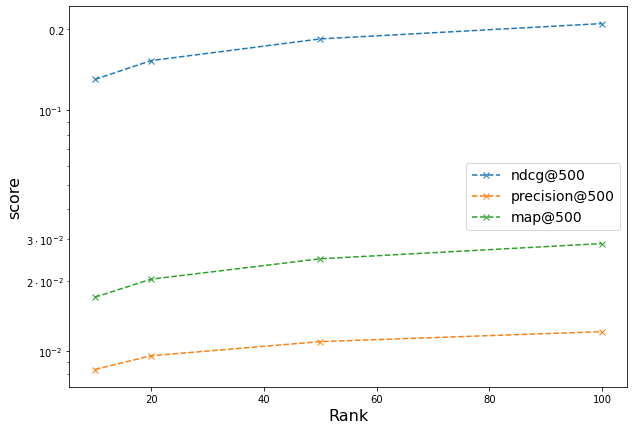

In [77]:
fig, ax = plt.subplots(figsize=[10,7])

ax.set_xlabel('Rank', fontsize = 16)
ax.set_ylabel('score', fontsize = 16)
ax.set_yscale('logit')

for method in ['ndcg', 'precision', 'map']:
    if method == 'map':
        score = MAP
    else:
        score = metrics[method]

    ax.plot(feature_set, score, '--x', label=f'{method}@500')
    ax.legend(prop={'size': 14})

plt.savefig('../figures/lenskit-rank.png')
plt.show()

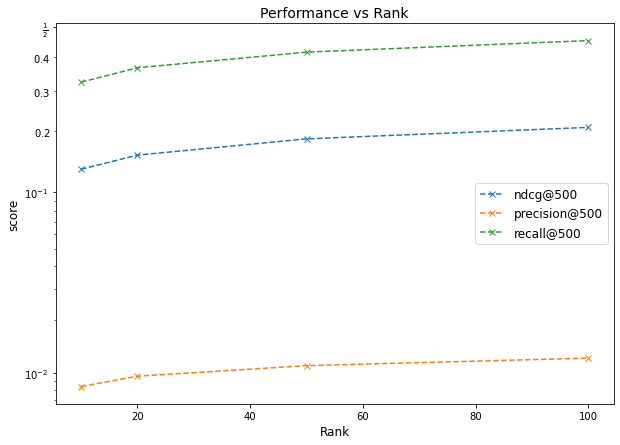

In [58]:
fig, ax = plt.subplots(figsize=[10,7])

ax.set_title('Performance vs Rank', fontsize = 14)

ax.set_xlabel('Rank', fontsize = 12)
ax.set_ylabel('score', fontsize = 12)
ax.set_yscale('logit')

for method in ['ndcg', 'precision', 'recall']:
    score = metrics[method]

    ax.plot(feature_set, score, '--x', label=f'{method}@500')
    ax.legend(prop={'size': 12})

plt.savefig('../figures/lenskit-rank.png')
plt.show()

### Plot the result vs time

In [35]:
runtime = metrics['TrainTime'] + metrics['RecTime']

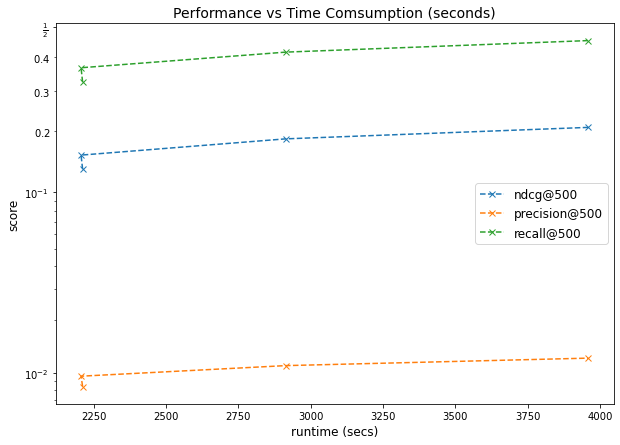

In [59]:
fig, ax = plt.subplots(figsize=[10,7])

ax.set_title('Performance vs Time Comsumption (seconds)', fontsize = 14)

ax.set_xlabel('runtime (secs)', fontsize = 12)
ax.set_ylabel('score', fontsize = 12)
ax.set_yscale('logit')

for method in ['ndcg', 'precision', 'recall']:
    score = metrics[method]

    ax.plot(runtime, score, '--x', label=f'{method}@500')
    ax.legend(prop={'size': 12})

plt.savefig('../figures/lenkit-time.png')
plt.show()